
# Retail Demo Store - Personalized discounts

In the previous notebooks, there were 3 campaigns created:
    - Personalized products for users.
    - Product to product recommendations.
    - Personalize reranking of products.

In this notebook we create an additional campaign:
    - Personalized discounts for users.
    
We will make use of the script that we have for generating interactions and the interested user is encouraged to look
there for more info:

    generators/generate_interactions_personalize.py

Users are already generated and in the repository, but these can be generated by
running `generate_users_json.py` in the same directory.

## Setup

In this notebook we can run the code either locally within the code repository root or uploaded to Sagemaker.

The below switch determines which one:

In [8]:
RUN_LOCALLY = False  # Set false for Sagemaker

### Import Dependencies and Setup Boto3 Python Clients

In [ ]:
import sys
sys.version

In [ ]:
# Import Dependencies

import boto3
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import requests
import csv
import sys
import botocore
import uuid
import yaml
import gzip
import shutil
import pathlib
from itertools import product as cartesian_product
from collections import Counter

from packaging import version
from random import randint
from botocore.exceptions import ClientError

%matplotlib inline

# Setup Clients
print('Setting up clients')

personalize = boto3.client('personalize')
personalize_runtime = boto3.client('personalize-runtime')
personalize_events = boto3.client('personalize-events')

cw_events = boto3.client('events')

servicediscovery = boto3.client('servicediscovery')
ssm = boto3.client('ssm')


### Configure Bucket and Data Location

In [ ]:
response = ssm.get_parameter(
    Name='retaildemostore-stack-bucket'
)

bucket = response['Parameter']['Value']     # Do Not Change

interactions_filename = "src/aws-lambda/personalize-pre-create-campaigns/data/interactions.csv"  # Do Not Change
products_filename = "src/products/src/products-service/data/products.yaml" # If working locally
products_filename_sagemaker = "data/products.yaml" # If on sagemaker
users_filename = "src/users/src/users-service/data/users.json.gz" # If working locally
users_filename_sagemaker = "data/users.json.gz" # If on sagemaker
print('Bucket: {}'.format(bucket))

interactions_key = "csvs/interactions.csv"

personalize_polling_lambda_rule_name = 'RetailDemoStore-PersonalizePreCreateScheduledRule'

In [10]:
if RUN_LOCALLY:
    # Let's get into the root directory to run the script:
    %cd ../..
else:
    # Let's get into the root directory to run the script:
    %cd ..
    pathlib.Path(products_filename).parents[0].mkdir(exist_ok=True, parents=True)
    pathlib.Path(users_filename).parents[0].mkdir(exist_ok=True, parents=True)
    shutil.copy(products_filename_sagemaker, products_filename)
    shutil.copy(users_filename_sagemaker, users_filename)


/home/ec2-user/SageMaker/retaildemostore-workshop/workshop


## Prepare Interaction Data

For more details see the notebook `1.1-Personalize.ipynb`

We will grab the products and items datasets locally so we can examine the interactions we generate.


### Create User-Items Interactions Dataset

In the notebook 1.1 we generated a new dataset that represents user interactions with items using a pre-defined shopper persona for each user to generate event types for products matching that persona.
There were events for viewing products, add products to a cart, checking out, and completing orders.

We additionally add Discount* (e.g. DiscountProductViewed) versions of these events.

We also ensure balance across categories and products in case certain categories gain too many products.

A more featured version of this simulation is available in this repository under the path `generators/generate_interactions_personalize.py`.

Delete any previous data (otherwise our script skips)

In [22]:
!rm -r src/aws-lambda/personalize-pre-create-campaigns/data/ || true

#### Create the interactions data (simulation)

In [23]:
if RUN_LOCALLY:
    %run generators/generate_interactions_personalize.py
else: 
    %run generate_interactions_personalize.py

Minimum interactions to generate: 675000
Starting timestamp: 1591803782 (2020-06-10 15:43:02)
Seconds increment: 11
Generating interactions... (this may take a few minutes)
Generated 26155 interactions so far (372.13 seconds to go)
Generated 81290 interactions so far (328.67 seconds to go)
Generated 136340 interactions so far (296.32 seconds to go)
Generated 191472 interactions so far (265.16 seconds to go)
Generated 246711 interactions so far (234.36 seconds to go)
Generated 301891 interactions so far (203.92 seconds to go)
Generated 356623 interactions so far (174.09 seconds to go)
Generated 411655 interactions so far (143.94 seconds to go)
Generated 466091 interactions so far (114.30 seconds to go)
Generated 520033 interactions so far (84.93 seconds to go)
Generated 575081 interactions so far (54.73 seconds to go)
Generated 630421 interactions so far (24.40 seconds to go)
Interactions generation done.
Total interactions: 675001
Total product viewed: 428293 (153392)
Total product add

#### Open and Explore the Interactions Dataset created

In [24]:
interactions_df = pd.read_csv(interactions_filename)
interactions_df

    # Product info is stored in the repository
with open(products_filename, 'r') as f:
    products = yaml.load(f, Loader=yaml.SafeLoader)

products_df = pd.DataFrame(products)

with gzip.open(users_filename, 'r') as f:
    users = json.load(f)

users_df = pd.DataFrame(users)

## Explore simulated data
#### Event type distribution

Chart the counts of each `EVENT_TYPE` generated for the interactions dataset. We're simulating a site where visitors heavily view/browse products and to a lesser degree add products to their cart and checkout.

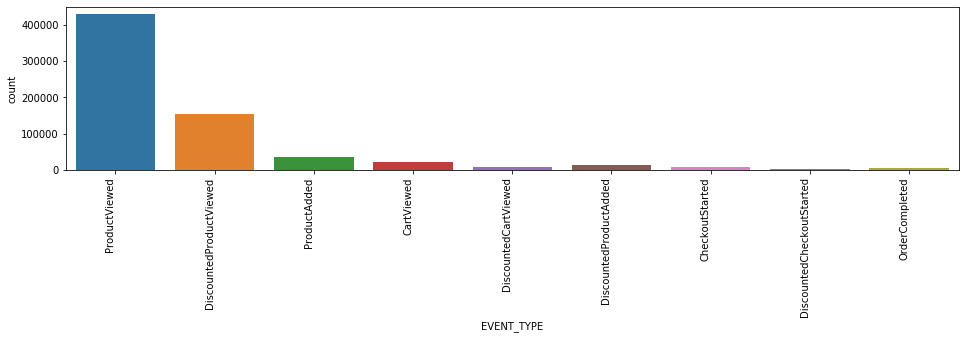

In [25]:
categorical_attributes = interactions_df.select_dtypes(include = ['object'])

plt.figure(figsize=(16,3))
chart = sns.countplot(data = categorical_attributes, x = 'EVENT_TYPE')
plt.xticks(rotation=90, horizontalalignment='right')
plt.show()

#### Discount persona vs event type distribution

Let us see how the event distribution came out

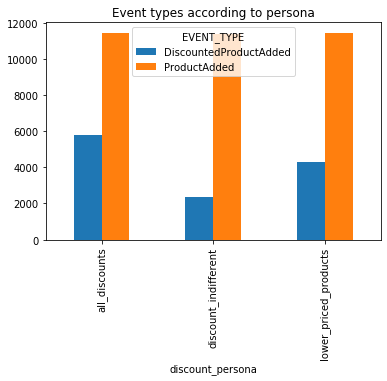

In [26]:
userevent_df = interactions_df[['USER_ID', 'EVENT_TYPE']]
userevent_df = userevent_df.loc[(userevent_df.EVENT_TYPE == 'ProductAdded') |
                                      (userevent_df.EVENT_TYPE == 'DiscountedProductAdded')]
users_df['id'] = users_df.id.astype('int64')
merged_df = userevent_df[['USER_ID', 'EVENT_TYPE']].merge(users_df, left_on='USER_ID', right_on='id')
counts = merged_df.groupby(['discount_persona', 'EVENT_TYPE'])[['id']].count().unstack()
counts = counts.droplevel(axis='columns', level=0)
counts.plot.bar()
plt.title('Event types according to persona')
plt.show()

#### Balance over products I

Let us have a careful look at product and category distributions.
The script ensures that there are small groups of products users tend to interact with, to maintain
strong training signals. If you look at the script you will see that although we choose
products randomly within a category, they are interacted with in small random groups in the category.


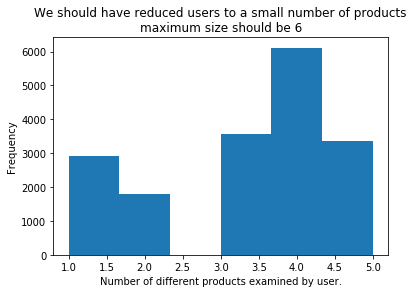

In [27]:
# PRODUCT_AFFINITY will have been imported since we ran the generate interactions script
# `generate_interactions_personalize.py`above.
# But we set it here anyway
PRODUCT_AFFINITY_N = 5

merged_df = interactions_df[['ITEM_ID', 'USER_ID']].merge(products_df, left_on='ITEM_ID', right_on='id')
useritems = merged_df.groupby(['USER_ID', 'category']).id.apply(set)
useritems.apply(len).plot.hist(bins=PRODUCT_AFFINITY_N+1)
plt.xlabel('Number of different products examined by user.')
plt.title(f'We should have reduced users to a small number of products\n'
          f'maximum size should be {PRODUCT_AFFINITY_N+1}')
# The peak at 1 is the male jewellery - there is only one product
plt.show()

#### Balance over products II
Ensuring that users interact with only overlapping subsets of products is not sufficient. We could require that users
only care about completely mutually exclusive sets of products but you would easily get cliques in your related
product recommendtions. So we ensure there is some balance in interactions between and within
categories explicitly but using balance information when sampling category and to add
interactions depending for a product.

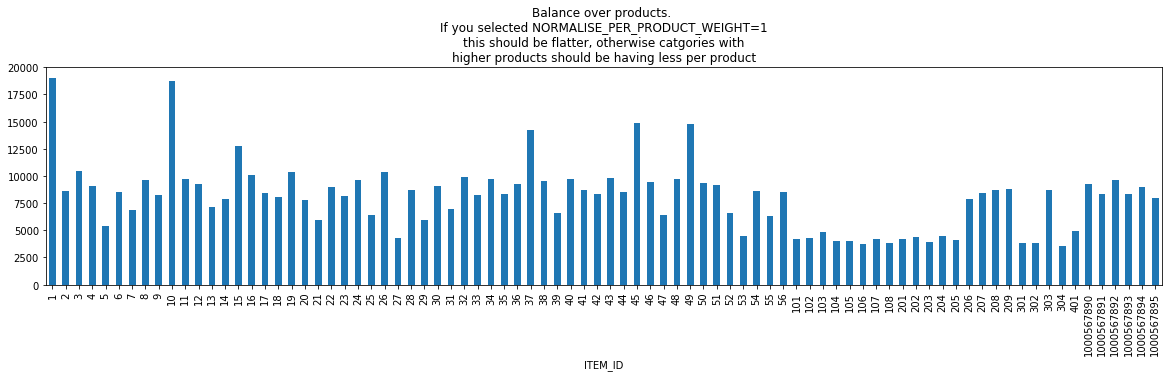

In [35]:
item_counts = interactions_df.groupby('ITEM_ID')['USER_ID'].count().plot.bar(figsize=[20,4])
plt.title('Balance over products. \nIf you selected NORMALISE_PER_PRODUCT_WEIGHT=1\nthis should be flatter, otherwise catgories with\n'
          'higher products should be having less per product')
plt.show()



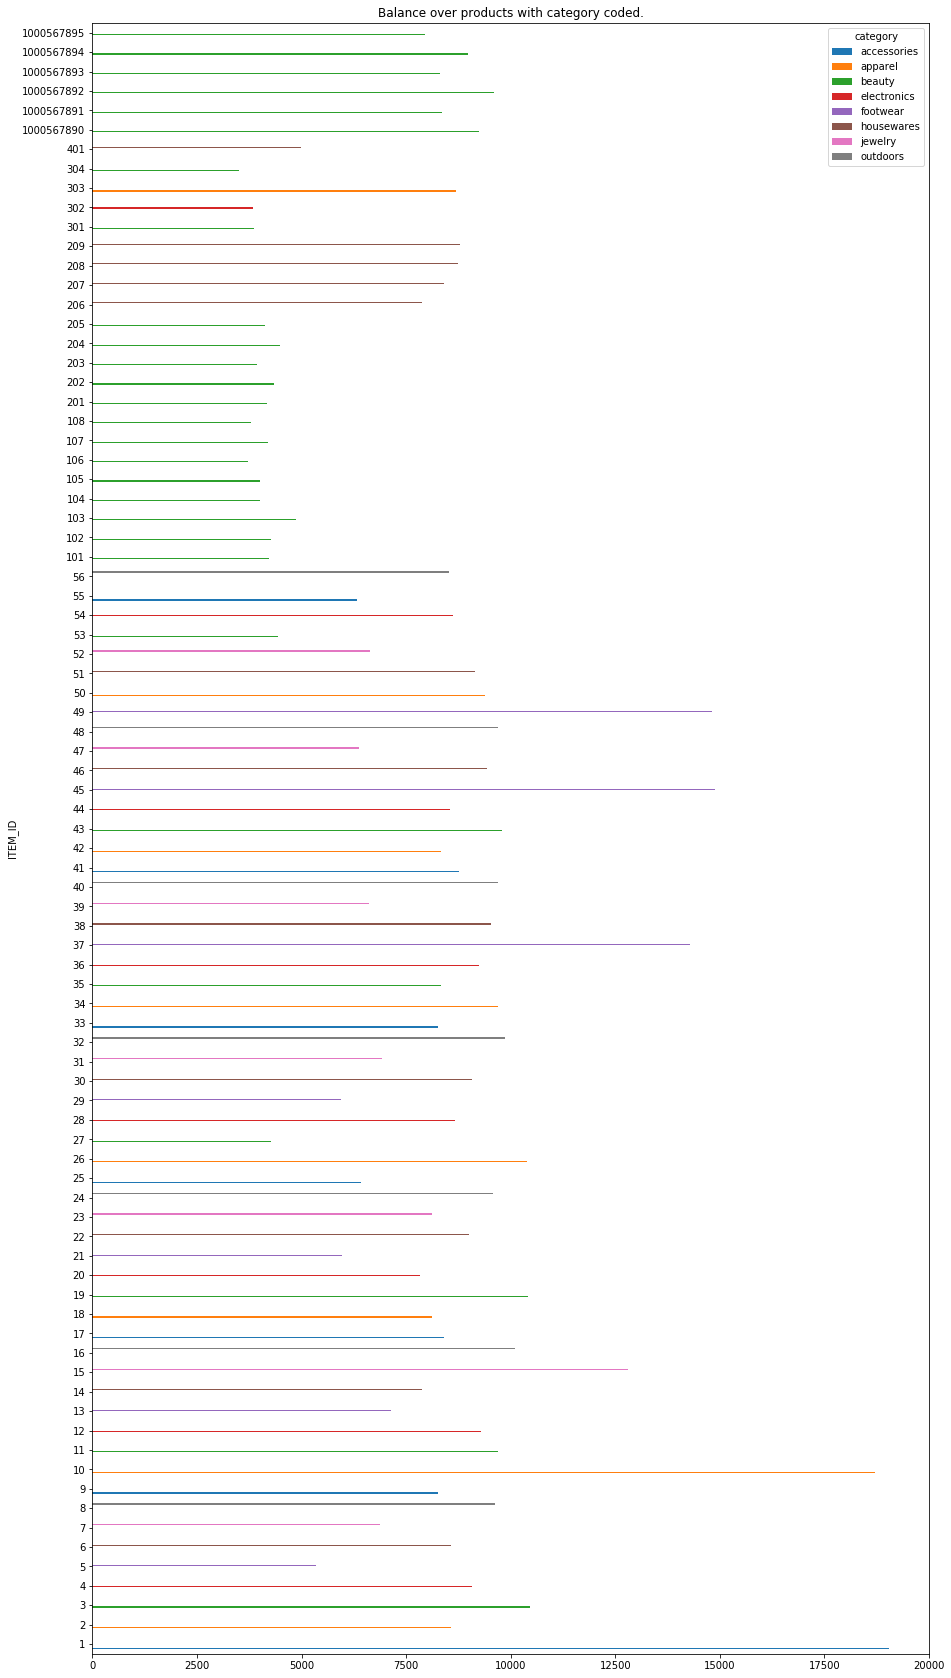

In [36]:
merged_df = interactions_df[['ITEM_ID', 'USER_ID']].merge(products_df, left_on='ITEM_ID', right_on='id')[['ITEM_ID', 'category', 'USER_ID']]
cntdf = merged_df.groupby(['ITEM_ID', 'category'])['USER_ID'].count()
cntdf.unstack().plot.barh(figsize=[15, 30])
plt.title('Balance over products with category coded.')
plt.show()

#### Prepare and Upload Data

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(interactions_key).upload_file(interactions_filename)
print('Uploaded to',bucket,'filename',interactions_key)

## Train and deploy

Now that we've prepared our three datasets and uploaded them to S3 we can use the retraining / deployment lambda to
deploy them for us.

We just have to tell it that we want to tear down everything that we have, and, after it has done that, retrain.

For this there are two steps:

#### 1. Set the SSM Parameter for the polling lambda

In [ ]:
STEP1 = {}  # take everything down

STEP2 = {  # Put up these 4 campaigns
    "retaildemostore-related-products": {"desired_versions": [0], "desired_active": 0, "minimum_available": 1},
    "retaildemostore-product-personalization": {"desired_versions": [0], "desired_active": 0, "minimum_available": 1},
    "retaildemostore-personalized-ranking": {"desired_versions": [0], "desired_active": 0, "minimum_available": 1},
    "retaildemostore-personalized-discounting": {"desired_versions": [0], "desired_active": 0, "minimum_available": 1}
}

train_configs = [STEP1, STEP2]

ssm.put_parameter(
    Name='retaildemostore-training-config',
    Description='Retail Demo Store Training Config',
    Value=json.dumps(train_configs),
    Type='String',
    Overwrite=True
)



#### 2. Set the Lambda for polling.

There is an event rule already for this, we just activate it.

In [ ]:
cw_events.enable_rule(Name=personalize_polling_lambda_rule_name)

Now we must wait. When the Lambda is finished, it will disable the rule.

In [ ]:
while cw_events.describe_rule(Name=personalize_polling_lambda_rule_name)['State'] == 'ENABLED':
    time.sleep(30)

## Test recommendations endpoint

Now we can test the discounts endpoint.

In [ ]:

response = servicediscovery.discover_instances(
    NamespaceName='retaildemostore.local',
    ServiceName='recommendations',
    MaxResults=1,
    HealthStatus='HEALTHY'
)

recommendations_service_instance = response['Instances'][0]['Attributes']['AWS_INSTANCE_IPV4']
print('Recommendations Service Instance IP: {}'.format(recommendations_service_instance))

In [18]:
# If running externally you can find the service instance URL in the Services nested CloudFormation stack output.
# recommendations_service_instance = 'dstor-LoadB-OWWMQ13NXQMB-425767778.eu-central-1.elb.amazonaws.com'
# recommendations_service_instance = 'dstor-LoadB-1VARZQCD7GAIO-1503383394.us-east-1.elb.amazonaws.com'

### Evaluate Offline Metrics for Solution Versions



In [30]:
def get_datset_group_arn_from_name(dsg_name):

    dataset_group_arn = None
    for dg in personalize.list_dataset_groups()['datasetGroups']:
        if dg['name'] == dsg_name:
            dataset_group_arn = dg['datasetGroupArn']
    return dataset_group_arn

dataset_group_arn = get_datset_group_arn_from_name('retaildemostore')

solutions = personalize.list_solutions(datasetGroupArn=dataset_group_arn)

for solution in solutions['solutions']:
    if 'retaildemostore-personalized-discounting' in solution['name']:
        solution_versions = personalize.list_solution_versions(solutionArn=solution['solutionArn'])
        for solution_version in solution_versions['solutionVersions']:
            discount_solution_version_arn = solution_version['solutionVersionArn']


get_solution_metrics_response = personalize.get_solution_metrics(
    solutionVersionArn = discount_solution_version_arn
)

print(json.dumps(get_solution_metrics_response, indent=2))

{
  "solutionVersionArn": "arn:aws:personalize:eu-west-1:266916629424:solution/retaildemostore-personalized-discounting-0/cfcbd1b4",
  "metrics": {
    "coverage": 0.2941,
    "mean_reciprocal_rank_at_25": 0.4457,
    "normalized_discounted_cumulative_gain_at_10": 0.4874,
    "normalized_discounted_cumulative_gain_at_25": 0.4942,
    "normalized_discounted_cumulative_gain_at_5": 0.4373,
    "precision_at_10": 0.1158,
    "precision_at_25": 0.0483,
    "precision_at_5": 0.1817
  },
  "ResponseMetadata": {
    "RequestId": "c2fe72a3-43dc-493d-86e5-2d4e07042657",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "content-type": "application/x-amz-json-1.1",
      "date": "Tue, 06 Oct 2020 10:33:34 GMT",
      "x-amzn-requestid": "c2fe72a3-43dc-493d-86e5-2d4e07042657",
      "content-length": "426",
      "connection": "keep-alive"
    },
    "RetryAttempts": 0
  }
}


#### Test the campaign

In [31]:
products[0]

{'id': 1,
 'name': 'Black Leather Backpack',
 'category': 'accessories',
 'style': 'bag',
 'description': 'Our handmade leather backpack will look great at the office or out on the town.',
 'price': 109.99,
 'image': '1.jpg',
 'featured': True}

In [92]:
product_ids = [22, 23, 24, 25, 26]

test_products = [product for product in products if product['id'] in product_ids]
for product in test_products:
    product['itemId'] = str(product['id'])

user_id = '1'
test_user = [user for user in users if user['id']==user_id][0]

print(json.dumps(test_products, indent=4))
print(json.dumps(test_user, indent=4))

[
    {
        "id": 22,
        "name": "Coffee Gift Package",
        "category": "housewares",
        "style": "consumable",
        "description": "Mug and Coffee gift set combination package.",
        "price": 39.99,
        "image": "3.jpg",
        "itemId": "22"
    },
    {
        "id": 23,
        "name": "Diamond Studded Classic Gold Bracelet",
        "category": "jewelry",
        "style": "bracelet",
        "description": "Dress up any outfit with this gold and diamond bracelet.",
        "price": 49.99,
        "image": "3.jpg",
        "gender_affinity": "F",
        "itemId": "23"
    },
    {
        "id": 24,
        "name": "Classic Fishing Pole",
        "category": "outdoors",
        "style": "fishing",
        "description": "Land a big one with our classic fishing rod and reel.",
        "price": 9.99,
        "image": "3.jpg",
        "itemId": "24"
    },
    {
        "id": 25,
        "name": "Red Leather Purse",
        "category": "accessories",
    

In [93]:
payload = {'userID': str(user_id), 'items':test_products, 'feature': 'pick_discounts' }
# If a feature is provided the relevant experiment will be engaged if it exists - see the experiment notebooks
print('Payload\n', json.dumps(payload, indent=4))
response = requests.post('http://'+recommendations_service_instance+'/choose_discounted', json=payload)

Payload
 {
    "userID": "1",
    "items": [
        {
            "id": 22,
            "name": "Coffee Gift Package",
            "category": "housewares",
            "style": "consumable",
            "description": "Mug and Coffee gift set combination package.",
            "price": 39.99,
            "image": "3.jpg",
            "itemId": "22"
        },
        {
            "id": 23,
            "name": "Diamond Studded Classic Gold Bracelet",
            "category": "jewelry",
            "style": "bracelet",
            "description": "Dress up any outfit with this gold and diamond bracelet.",
            "price": 49.99,
            "image": "3.jpg",
            "gender_affinity": "F",
            "itemId": "23"
        },
        {
            "id": 24,
            "name": "Classic Fishing Pole",
            "category": "outdoors",
            "style": "fishing",
            "description": "Land a big one with our classic fishing rod and reel.",
            "price": 9.99,
 

In [94]:
print('Result\n', json.dumps(json.loads(response.text), indent=4))
print('Discounted IDs', [a['itemId'] for a in json.loads(response.text) if a['discounted']])

Result
 [
    {
        "id": 22,
        "name": "Coffee Gift Package",
        "category": "housewares",
        "style": "consumable",
        "description": "Mug and Coffee gift set combination package.",
        "price": 39.99,
        "image": "3.jpg",
        "itemId": "22",
        "discounted": true
    },
    {
        "id": 23,
        "name": "Diamond Studded Classic Gold Bracelet",
        "category": "jewelry",
        "style": "bracelet",
        "description": "Dress up any outfit with this gold and diamond bracelet.",
        "price": 49.99,
        "image": "3.jpg",
        "gender_affinity": "F",
        "itemId": "23",
        "discounted": false
    },
    {
        "id": 24,
        "name": "Classic Fishing Pole",
        "category": "outdoors",
        "style": "fishing",
        "description": "Land a big one with our classic fishing rod and reel.",
        "price": 9.99,
        "image": "3.jpg",
        "itemId": "24",
        "discounted": false
    },
    {


### Change the discounted items using real-time personalize interface

According to the documentation ( https://docs.aws.amazon.com/personalize/latest/dg/getting-real-time-recommendations.html ) - the reranking recipe does not currently support real-time recommendations. However, were it to, we would expect the realtime event API to result in different recommendations.

In the below we go through the motions of what this would look like.

We will generate a lot of related interactions to our target item. Let us generate a set of related target items by looking directly at our data.

In [98]:

# Get the Cartesian products of all items for each user
cproducts = interactions_df.groupby('USER_ID')['ITEM_ID'].apply(set).apply(lambda x: cartesian_product(x,x)).apply(list)
# Get all the products that are paird with the target product (25) and count the number of users they co-occur
products25 = Counter(sum(([a[0] for a in v if a[1] == 25] for v in cproducts.values), []))
# Choose the 5 productws that co-occur with 25 the most - here we print with their frequencies
related_items = pd.Series(products25).nlargest(5)
print(related_items)
# Here we throw away the frequencies and stay with an array of related items.
related_items = related_items.index.values
related_items

25    568
17    324
9     300
55    296
23    280
dtype: int64


array([25, 17,  9, 55, 23])

Let's see what these related products are (Personalize didn't choose them - we just looked at commonly colocated products).

In [95]:
print(json.dumps([product for product in products if product['id'] in related_items], indent=4))

[
    {
        "id": 9,
        "name": "Black Leather Shoulder Bag",
        "category": "accessories",
        "style": "bag",
        "description": "Our handmade leather shoulder bag will look great at the office or out on the town.",
        "price": 109.99,
        "image": "2.jpg",
        "gender_affinity": "F"
    },
    {
        "id": 17,
        "name": "Black Women's Purse",
        "category": "accessories",
        "style": "bag",
        "description": "Spacious and stylish in a single bag.",
        "price": 109.99,
        "image": "3.jpg",
        "gender_affinity": "F"
    },
    {
        "id": 23,
        "name": "Diamond Studded Classic Gold Bracelet",
        "category": "jewelry",
        "style": "bracelet",
        "description": "Dress up any outfit with this gold and diamond bracelet.",
        "price": 49.99,
        "image": "3.jpg",
        "gender_affinity": "F",
        "itemId": "23"
    },
    {
        "id": 25,
        "name": "Red Leather Purse",

Yes they look related. Get tracking ID so we can push events (note that this does not yet work with the reranking solution) .

In [ ]:
event_tracking_id = ssm.get_parameter(Name='retaildemostore-personalize-event-tracker-id')['Parameter']['Value']
event_tracking_id

Here we simulate the relevant event type with the related items, wait 10 seconds to ensure any changes have propagated.

In [96]:
session = str(uuid.uuid4())
responses = []
for related_item_id in related_items:
    for i in range(20):
        response = personalize_events.put_events(
            trackingId = event_tracking_id,
            userId = user_id,
            sessionId = session,
            eventList = [
                {
                    'eventId': str(uuid.uuid4()),
                    'eventType': 'DiscountedProductViewed',
                    'itemId': str(related_item_id),
                    'sentAt': int(time.time())
                }
            ]
        )
        responses += [response]
print('Done. Sleeping.')
time.sleep(10)


Done. Sleeping.


Now get the new set of recommendations.

In [97]:
payload = {'userID': str(user_id), 'items':test_products, 'feature': 'pick_discounts' }
# If a feature is provided the relevant experiment will be engaged - see the experiment notebooks
print('Payload\n', json.dumps(payload, indent=4))
response = requests.post('http://'+recommendations_service_instance+'/choose_discounted', json=payload)
print('Result\n', json.dumps(json.loads(response.text), indent=4))
print('Discounted IDs', [a['itemId'] for a in json.loads(response.text) if a['discounted']])

Payload
 {
    "userID": "1",
    "items": [
        {
            "id": 22,
            "name": "Coffee Gift Package",
            "category": "housewares",
            "style": "consumable",
            "description": "Mug and Coffee gift set combination package.",
            "price": 39.99,
            "image": "3.jpg",
            "itemId": "22"
        },
        {
            "id": 23,
            "name": "Diamond Studded Classic Gold Bracelet",
            "category": "jewelry",
            "style": "bracelet",
            "description": "Dress up any outfit with this gold and diamond bracelet.",
            "price": 49.99,
            "image": "3.jpg",
            "gender_affinity": "F",
            "itemId": "23"
        },
        {
            "id": 24,
            "name": "Classic Fishing Pole",
            "category": "outdoors",
            "style": "fishing",
            "description": "Land a big one with our classic fishing rod and reel.",
            "price": 9.99,
 

No change because it is not a real-time event supporting recipe.


## Cleanup

This notebook has assumed you have deployed the full demo with CloudFormation. When you delete with CloudFormation all
the items you have worked with in this notebook will be taken down.